# Luria-Delbrück estimator corrected for death probability according to a continuous time model (Section 3.5.4)

This notebook is a Python implementation of the simulations described in section 3.5.4.

It has been used _anytree_ library, from GitHub, to build the tree data structure that represent a generational tree.

Repository: https://github.com/c0fec0de/anytree

Documentation: https://anytree.readthedocs.io/

In [1]:
# import
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import binom
from anytree import Node, RenderTree

# Check that used machine supports int64
# max int64 ~ 9*10^18
if(np.random.randint(0, high = 9223372036854775808)):
    print("Ok, this machine supports int64!")

Ok, this machine supports int64!


## Implementation of the Luria-Delbrück stochastic experiment 
Same class as in *LD.py*, the only difference is the method *test_LD_estimator_no_dead_estimated()*.

This method is here implemented according to the discrete time model (equations 16 and 17).

In [2]:
class LD:
    
    def __init__(self, gen = 5, min_size = 0, bases = 100E+6,  
                 death_prob = 0., mu = 3E-9, N0gen = 0,  seq_err = 0.001, 
                 cov = 128, quiet = True, accept_extinct = False):
        """ 
        Cells are rapresented as nodes in a binary tree structure.
        Population tree is built based on:
        - minimum extant cell number, if an 'min_size' positive argument is passed,
        - fixed number of generation, otherwise.
        
        If 'accept_extinct' is False only non extinct trees are accepted.
        
        """
        
        # Option for the run
        self._quiet = quiet # if 'True' hide some prints
        self._min_size = min_size # if positive is the minimum size to reach
        self._gen = gen # number of generations if no 'min_size' is passed
        self._accept_extinct = accept_extinct
        
        #-----------------------
        # SIMULATION PARAMETERS
        #-----------------------
        
        # Cell's parameters
        self._bases = bases # cell's bases number (realizations of the mutation process) 
        self._death_prob = death_prob # death probability per generation d/(d+b)
        self._mu = mu # real mutation rate per generation
        
        # Parameters for error models
        self._N0gen = N0gen # generations from reference to clone
        self._seq_err = seq_err # seq error rate per base
        self._cov = cov # coverage
        self._threshold = 0. # threshold for frequencies
        self._mean_ploidy = 0 # mean ploidy of cells
        
        #-----------------------
        # RESULTS
        #-----------------------
        
        # Mutation rate estimates for different methods
        self._mu_est = 0. # estimated mutation rate (clean)
        self._mu_est_N0gen = 0. # estimated mutation rate considering also mutation prior to cloning
        self._mu_est_N0_threshold = 0 # mutation prior to cloning and threshold
        self._mu_est_seq_err = 0. # estimated mutation rate considering also sequencing errors
        self._mu_est_seq_err_threshold = 0. #sequencing errors and threshold
        self._mu_est_ploidy = 0.
        self._mu_est_ploidy_with_correction = 0.
        self._mu_est_no_dead = 0. # estimated mutation rate counting only edges that have alive progeny
        
        #-----------------------
        # CELLS DATA STRUCTURES 
        #-----------------------
        
        # If the tree is built for fixed number of generation
        # maximum cell index is known and we can use a list as "static"
        self._static_list_size = self.max_imax(self._gen) + 1
        self._population = [None for _ in np.arange(self._static_list_size)] # List of population nodes
        
        self._extant =  0 # number of nodes in the last generation
        self._num_layers = 0 # number of layers (generations) in the tree 
        self._extinct = True # bool to check if tree is extinct before reaching the right size
        self._imax = 0 # max cell index = number of nodes in the whole tree
        
        self._min_extant_id = 0 # min ID between extant cells
                                # because ID are ordered every cell with ID in 
                                # [self.min_extant_id, self.imax] is an extant cell
        
        self._count_with_alive_progeny = 0 # number of cell that have alive progeny (descendants)
                                           # in the whole tree (extant cells are counted)
        #---------------------------
        # MUTATIONS DATA STRUCTURES 
        #---------------------------     
        self._mutation_frequencies = [] # mutation frequency vector
        self._count_mutation = 0 # counter for mutiations that are not extict in the last layer
        self._n_mut_prior = 0 # mutation occurring in N0gen from reference to clone zero (root)
        
        
        # Fill population data structure (tree generation)
        
        # Check if extinct trees are accepted
        if self._accept_extinct:
            # Extinct trees are accepted
            self.generate_tree()
        else:
            #Extinct trees are discarded          
            while(self._extinct):
                #generate new tree
                self.generate_tree()
        
        # we can not estimate mut rate for an extinct tree
        if not self._extinct:
            # Generate mutation
            self.generate_mutations()
            # Test "standard" estimator (clean from errors)
            self.test_LD_estimator()
        else:
            if not self._quiet:
                print("Tree is extinct, can not estimate mutation rate.")
       
    def generate_tree(self):
        """
        Tree is built based on:
        - minimum extant cell number, if an 'min_size' positive argument is passed,
        - fixed number of generation, otherwise.
        """
        
        #set (or reset in case of extinction) cells' data structures 
        self._static_list_size = self.max_imax(self._gen) + 1
        self._population = [None for _ in np.arange(self._static_list_size)] # List of population nodes
        
        self._extant =  0 # number of nodes in the last generation
        self._num_layers = 0 # number of layers (generations) in the tree 
        self._imax = 0 # max cell index = number of nodes in the whole tree
        self._min_extant_id = 0
        #set extinction flag to False
        # will be set to 'True' if extintion happens during tree's generation
        self._extinct = False 
        
        # if minimum size parameter is passed
        if self._min_size > 0:
            #build tree until minimum population size
            self.generate_tree_min_size()
        else:
            # there is no minimum size
            # build for fixed number of generation
            self.generate_tree_fixed_gen()
        
    def generate_tree_min_size(self):
        """
        Generate population for fixed minimum size.
        """            
        # print 'start'
        if not self._quiet:
            print("\n\nGenerating new tree...")
            
        # Every cell is represented as a node in binary tree
        # Create cell zero (root)
        self._population[0] = Node(0)
        self._imax = 0
        self._extant = 1
        self._min_extant_id = 0
        
        # current number of layers in the tree is zero
        self._num_layers = 0
        
        #while number of extant cells is less than minimum size
        while(self._extant < self._min_size):
            # if tree is not extinct
            if not self._extinct:
                #add generation (layer)
                self.add_generation() 
            else:
                #tree is estinct
                #stop generations
                break         
    
    def generate_tree_fixed_gen(self):
        """
        Generate population for fixed generation number.
        """
        # print 'start'
        if not self._quiet:
            print("\n\nGenerating new tree...")
        
        # Every cell is represented as a node in binary tree
        # Create cell zero (root)
        self._population[0] = Node(0)
        self._imax = 0
        self._extant = 1
        self._min_extant_id = 0
        
        # current number of layers in the tree is zero
        self._num_layers = 0
        
        # for each generation from 0 (now) to (fixed gen number -1)
        for current_gen in range(self._gen):
            # if tree is not extinct
            if not self._extinct:
                #add generation (layer)
                self.add_generation()
            else:
                #tree is extinct
                #stop generations
                break
                
    def add_generation(self):
        """
        Add one generation to the tree.
        """
        # save current max cell's index
        old_imax = self._imax
        
        # for every cell (node) in the last generation (layer)
        for parent in self.get_last_layer():
            # attempt to generate two daughters
            for attempt in np.arange(2):
                # if death event not verified
                if (np.random.random() > self._death_prob): 
                    # make new cell
                    self._imax += 1
                    # add cell to population
                    # check if "static" use of the list is possible
                    # if imax is too large it means that the list is full
                    if self._imax < self._static_list_size:
                        # insert it in the static list 
                        self._population[self._imax] = Node(self._imax, parent = parent)
                    else:
                        #"static" list is full
                        # it happens when building tree for min_size
                        self._population.append(Node(self._imax, parent = parent))
                        
        
        # update layers' counter            
        self._num_layers += 1
        # update extant number
        self._extant = self._imax - old_imax
        self._min_extant_id = old_imax + 1
        
        # Check for extinction:
        # if no cells were added this generation
        if self._extant == 0:
            # tree is extinct
            self._extinct = True
            # zero extant 
            self._extant = 0
            # minimum extant id is not defined
            self._min_extant_id = None
            # print
            if not self._quiet:  
                    print("\n\nEmpty layer! Tree is extinct.")
                    self.print_tree()
        else:
            #tree is not extinct
            self._extinct = False
              
    def generate_mutations(self):
        """
        Generate mutations and assign to specific cell (mutant).
        For every mutant check how many descendants it has
        in extant cells. 
        Compute mutation frequency as the number of mutants in extant
        cells for each mutation.
        """
        # we have 'self._extant' extant nodes 
        # The number of mutation attempts is
        # imax * bases
        # compute total number of mutations
        attempts = int(self._bases*self._imax)
        n_mutations = np.random.binomial(attempts, self._mu)
        
        if not self._quiet:
            print("\n\nMutation attempts: " + str(attempts))
            print("Mutations number: " + str(n_mutations))
        
        # assign the mutations to trees
        for _ in np.arange(n_mutations):
            
            # overall index of mutant is sampled uniformly in [1, imax]
            rand_int = 1 + np.random.randint(attempts)
            
            if not self._quiet:
                print("Rand_int: " + str(rand_int) + ", imax: " + str(self._imax) + 
                      ", randint/imax: " + str(rand_int/self._imax) )
                
            # compute cellID of mutant in tree
            cellID = rand_int % self._imax
            # baseID is computed as in the original code 
            # but it's not used (here nor there)
            baseID = rand_int / self._imax
            
            # check how many mutants there are in progeny
            n_mutants = self.count_alive_progeny(cellID)
            
            # compute frequency = n_mutants/n_extant
            frequency = n_mutants / self._extant 
                
            # check if mutation is not extinct on tree
            if n_mutants != 0 :         
                # save mutation frequency
                self._mutation_frequencies.append(frequency)
                # increment counter for mutations that are not extict in the last layer
                self._count_mutation += 1
                
            if not self._quiet:
                print("Mutant cell ID: " + str(cellID) + ", Mutants in progeny: " + str(n_mutants) +
                          ", Extant: " + str(self._extant) + ", Frequency: " + str(frequency) )
        if not self._quiet:
            print("\n\n")
            
    def test_LD_estimator(self):
        """
        Estimate mutation rate with "standard" formula:
        
        P = (# mutations not extinct in last layer)/(# bases)
        
        mu = - log(1-P)/(imax)
        """
        
        # clean mut rate estimate
        self._mu_est  = - math.log(1 - self._count_mutation/self._bases)
        self._mu_est /= self._imax
        
        if not self._quiet:
            print("Clean mutation count: ", self._count_mutation)
            print("Clean mutation rate estimated: "+str(self._mu_est))
            print("\n\n")
    
    #----------------------------
    # ERROR MODELS
    #----------------------------
    
    # role of N0_gen
    def test_LD_estimator_N0gen(self, N0gen = 0):
        
        """ 
        Test the estimator in presence of errors due to mutations 
        occurring in 'N0gen' generations from reference to clone (as in the original code). 
        Compute attempts as:
                                mutation attempts = N0gen*bases
        
        Mutation realizations are sampled from binomial distribution with probability of succes
        equals to mutation rate.
        This mutation have frequency 1 because they are already present in root cell.
        Total mutations are computed as the sum of prior mutations number and mutation counter.
        
        Mutation rate mu is than estimated using the "standard" formula:
        
        P = (# total mutations )/(# bases)
        
        mu = - log(1-P)/(imax)
        
        """
        
        self._N0gen = N0gen
    
        # Compute mutations prior to cloning
        attempts = self._N0gen * self._bases # num attempt as in the original code
        self._n_mut_prior = np.random.binomial(attempts, self._mu)
        
        # load mutation vector with prior mutations (frequency = 1)
        for _ in np.arange(self._n_mut_prior) :
            self._mutation_frequencies.append(1.)
        
        # test LD estimator:
        # total mutations are computed as the sum of prior mutations number and mutation counter
        self._mu_est_N0gen = - math.log(1 - (self._count_mutation + self._n_mut_prior)/self._bases)
        self._mu_est_N0gen /= self._imax
        
        if not self._quiet:
            print("Estimate with prior mutations: "+str(self._mu_est_N0gen))
            
        #test estimator with threshold
        count = 0 # count mutations that are fine with threshold
        
        # simulated thresholding: frequency < 0.95
        for fobs in self._mutation_frequencies:
            if fobs<=0.95 :
                count += 1
                
        self._mu_est_N0gen_threshold = - math.log(1 - count/self._bases)
        self._mu_est_N0gen_threshold /= self._imax
        
    # role of sequencing errors
    def test_LD_estimator_seq_err(self, seq_err = 0., threshold = 1/32.):
        
        """ Test the estimator in presence of errors due to sequencing.
        (As it is in the original code) """
        
        self._seq_err = seq_err
        self._threshold = threshold
        
        # sampling due to coverage
        # sequencing error epsilon ~ 0.1% per base
        # proposition: could both be modeled as Binomials
        
        # Errors on mutations
        count = 0 # count mutations that are fine with thresholds
        count_no_threshold = 0 # count mutations
        reads = list([]) # estimated reads
        mutobs = list([]) # empirical mutation frequency vector
        
        for frequency in self._mutation_frequencies:
            
            # sampling of coverage sequences
            R1 = np.random.binomial(self._cov, frequency)
            
            # seq error leading to false negatives
            R2 = np.random.binomial(R1, self._seq_err)
            
            R3 = np.random.binomial(self._cov - R1, self._seq_err)
            
            # estimated reads
            reads.append(R1-R2+R3)
            
            # empirical mutation frequency vector
            fobs = float((R1-R2+R3)/self._cov)
            mutobs.append(fobs)
            
            if not self._quiet:
                print("Frequency :", frequency)
                print("R1 = ", R1, ",R2 =", R2,",R3 =", R3)
                print("Simulated reads", R1-R2+R3)
                print("Simulated observed frequency", fobs)
                
            # simulated thresholding
            if( (fobs>=(self._threshold)) & (fobs<=0.95) ):
                count += 1
                if not self._quiet:
                    print(fobs, "counted")
            else:
                if not self._quiet:
                    print(fobs, "not counted")
            
            # no threshold comparison
            if (fobs>0.) :
                count_no_threshold += 1
        
        if not self._quiet:
            print("Mutation count: " + str(count)) #debug
            print("Mutation count (no threshold): " + str(count_no_threshold)) #debug
            
        # errors on non-mutated bases (frequency is zero)
        
        # these errors give me a false positve if the fraction of reads
        # with a mutation is higher than the threshold (1/extant)

        R1 = self._cov*self._threshold

        # in the original code is
        # errbias = gsl_cdf_binomial_Q(r1+1, seqerr, cov);
        # in the gsl library documentation is explained:
        # "These functions compute the cumulative distribution 
        # functions 𝑃(𝑘),𝑄(𝑘) for the binomial distribution with parameters p and n."
        # I'm not sure if this correspond to CDF Binomial of SciPy.
        # If I use binom.cdf i get err_bias ~ 1 and then math error 
        # in the estimator due to log(0)
        # maybe gsl_cdf_binomial_Q = (1 - binom.cfd) ?
        
        err_bias = 1 - binom.cdf(R1+1, self._cov, self._seq_err)
        
        if not self._quiet:
            print("err_bias: " + str(err_bias)) #debug
        
        # now I assume that it is binomial
        # we need to aclude the mutate bases
        count += np.random.binomial( self._bases - count, err_bias )
        count_no_threshold += np.random.binomial( self._bases - count, err_bias )
        
        # Test LD estimator
        if not self._quiet:
            print ("Observed P: "+str((count)/self._bases)) #debug
        
        self._mu_est_seq_err_threshold = - math.log(1 - (count)/self._bases)
        self._mu_est_seq_err_threshold /= self._imax
        
        self._mu_est_seq_err = - math.log(1 - (count_no_threshold)/self._bases)
        self._mu_est_seq_err /= self._imax
        
        if not self._quiet:
            print("Estimate with sequencing errors and threshold: "+str(self._mu_est_seq_err_threshold))
            print("Estimate with sequencing errors and no threshold: "+str(self._mu_est_seq_err))
            
    # estimate the role of ploidy
    def test_LD_estimator_ploidy(self, mean_ploidy, threshold = 1./32):
        
        # mean ploidy for the simulation
        self._mean_ploidy = mean_ploidy
        
        self._threshold = threshold
        
        # ploidy is assumed to be distrtibuted as a Poisson distribution
        # usually ploidy is in [1,5] so we model
        # ploidy ~ 1 + Poisson (mean_ploidy - 1)
        
        lam = mean_ploidy - 1 
        
        mutobs = list([]) # empirical mutation frequency vector
        count = 0 # count mutations 
        count_with_correction = 0 # count mutations considering mean ploidy
        
        for frequency in self._mutation_frequencies:
            
            #extract random ploidy
            ploidy = 1 + np.random.poisson(lam=lam)
            
            # sampling of coverage sequences
            R1 = np.random.binomial(self._cov/ploidy, frequency)
            
            #here we ignore sequencing errors
            
            # empirical mutation frequency vector
            fobs = float(R1/self._cov)
            mutobs.append(fobs)
            
            if not self._quiet:
                print("Frequency :", frequency)
                print("Random ploidy:", ploidy)
                print("R1", R1)
                print("Observed frequency:", fobs)
                print("Corrected observed frequency for mean ploidy", float(fobs*ploidy))
            
            # simulated thresholding
            if( (fobs>=(self._threshold)) & (fobs<=0.95) ):
                count += 1
                if not self._quiet:
                    print(fobs, "counted")
            else:
                if not self._quiet:
                    print(fobs, "not counted")
                    
            # simulated thresholding with correction
            # fobs = R1/(coverage/ploidy) = R1*ploidy/coverage = fobs*ploidy
            fobs *= ploidy
            
            if( fobs >= self._threshold ):
                count_with_correction += 1
                if not self._quiet:
                    print(fobs, "counted with correction")
            else:
                if not self._quiet:
                    print(fobs, "not counted with correction")
                    
        # Test LD estimator
        self._mu_est_ploidy = - math.log(1 - (count)/self._bases)
        self._mu_est_ploidy /= self._imax
        
        self._mu_est_ploidy_with_correction = - math.log(1 - (count_with_correction)/self._bases)
        self._mu_est_ploidy_with_correction /= self._imax
        
        if not self._quiet:
            print("\n\n")
            print("Mutation count with ploidy: " + str(count)) #debug
            print("Mutation count with ploidy and correction: " + str(count_with_correction)) #debug
            print("Estimate with ploidy: " + str(self._mu_est_ploidy))
            print("Estimate with ploidy and correction: "+str(self._mu_est_ploidy_with_correction))
            
    # estimate mut rate counting only edges that have alive progeny
    def test_LD_estimator_no_dead(self):
        """
        Correct the "stadard" mutation rate estimator taking into account 
        cell's death. 
        
        In the "standard" estimator the number of attempts (Poisson Process)
        are considered to be equal the total number of cell in the whole tree.
        (max cell's index, imax)
        
        Here we have 'count_with_alive_progeny':
        
                         P = (# total mutations )/(# bases)
        
                       mu = - log(1-P)/(count_with_alive_progeny)
        
        'count_with_alive_progeny' is the number of cells (node) in the whole tree that have 
        alive progeny (i.e. the number of cells in the whole tree that have descendants in 
        extant cells).
        
        Note that every cells is considered to be part of his own progeny, so extant cells 
        are counted in 'count_with_alive_progeny'.
        """
        
        #Call the function that update 'self._count_with_alive_progeny'
        self.count_with_alive_progeny()
        
        # debug:  
        # if extant = 32 and death_prob = 0. 
        # than imax = 62 and count_alive = 62
        #
        #print("imax " + str(self._imax))
        #print("count_alive " + str(self._count_with_alive_progeny))
        
        # in the original code are compared the clean estimate
        # and the one counting only edges that have alive progeny
        # so here we ignore error models
        
        # Test "corrected" LD estimator for death prob
        self._mu_est_no_dead = - math.log(1 - self._count_mutation/self._bases)
        self._mu_est_no_dead /= self._count_with_alive_progeny
        
        if not self._quiet:
            print("Clean mutation rate estimated (no dead progeny): "+str(self._mu_est_no_dead))  
            
    # estimate mut rate using analytic estimation of the 
    # number of cells with alive progeny (extant included)
    def test_LD_estimator_no_dead_estimated(self):
        
        # in the original code are compared the clean estimate
        # and the one counting only edges that have alive progeny
        # so here we ignore error models
        
        # "age ove the tree" = number of generations
        t = self._num_layers 
        
        # we count the cumulative mean number of cell
        # with at least one alive daughter
        # from generation zero to the second-last one
        count_with_alive_progeny = 0
        for i in range(1, t): #from i=1 to i=t-1
            count_with_alive_progeny += ( (2*(1-self._death_prob))**i)*1.*(1-self._death_prob**2)
            
        # we add also add extant cells number
        count_with_alive_progeny += self._extant
        
        # Test "corrected" LD estimator for death prob
        self._mu_est_no_dead_estimated = - math.log(1 - self._count_mutation/self._bases)
        self._mu_est_no_dead_estimated /= count_with_alive_progeny
        
        if not self._quiet:
            print("Clean mutation rate estimated (no dead progeny estimate): "+str(self._mu_est_no_dead_estimated))  
    
    
    #----------------------------
    # UTILTIES
    #----------------------------
    
    def max_imax(self, gen):
        """
        Return max possible cell index given the number of generations. 
        """
        imax = 0
        for n in range(gen):
            imax += 2*2**(n)
        return imax
    
    def get_last_layer(self):
        """
        Return list of nodes (cell) in the last layer
        """
        # last layer is the list of extant nodes
        
        #return list of elements in population list 
        # population = [ Node(0), Node(1), ..., Node(min_extant_id), ..., Node(imax), None, ..., None]
        # population = [ root cell, ..., ..., ..., first extant, ..., ..., last extant, None, ..., None]
        
        #return 
        #[first extant, ..., ..., last extant]
        return self._population[self._min_extant_id: self._imax+1]
        
    def print_tree(self):
        """
        Print generational tree.
        """
        for pre, _, node in RenderTree(self._population[0]):
            print("%s%s" % (pre, node.name))
            
    def count_alive_progeny(self, cellID):
        """
        Check how many alive mutants there are in the progeny of cell with specific ID.
        """

        # There are two cases:
        # 1. mutant cell is an extant cell -> no progeny other than itself
        # 2. mutant cell is not an extant cell -> check for alive descendants
        
        if cellID >= self._min_extant_id:
            # Case 1. mutant cell is an extant cell
            # than the only alive mutant is itself
            return 1
        else:
            # Case 2. mutant cell is not an extant cell 
            # than check for alive descendants:
            # get the list of ID of all descendats of cellID
            descendant_IDs = [node.name for node in self._population[cellID].descendants]
            #initialize mutant counter
            count_alive_mutants = 0
            #for each of them
            for descendantID in descendant_IDs:
                #if descendantID is bigger than or equal to 'min_extant_ID' it's an extant cell
                if descendantID >= self._min_extant_id:
                    # count it as an alive mutant
                    count_alive_mutants += 1
            #return counter
            return count_alive_mutants
        
    def count_with_alive_progeny(self, node_list = None):
        """
        Function to update 'count_with_alive_progeny':
        
        'count_with_alive_progeny' is the number of cells (node) in the whole tree that have 
        alive progeny (i.e. the number of cells in the whole tree that have descendants in 
        extant cells).  
        
        Note that every cells is considered to be part of his own progeny, so extant cells 
        are counted in 'count_with_alive_progeny'.
        
        This function operates recursively (one call for each layer) starting from last layer.
        """
        
        # If no list is passed
        if node_list == None :
            # This is the first call to this function 
            self._count_with_alive_progeny = 0
            # Operates on last layer of the tree
            
            # Take the list of nodes (cell) in the last layer
            node_list = self.get_last_layer()
        
        # If node_list is only the cell zero we have finished
        # Don't count cell zero
        # ("node.name" to compare int type)
        if node_list[0].name == 0:
            # End
            return 
            
        ancestors_list = []
        
        for i in np.arange(np.shape(node_list)[0]):
            #for every element of the node_list
            #i is the index of the element in the node_list
            
            # Count this node
            self._count_with_alive_progeny += 1
            
            # Fill ancestors list
            
            # If it is the first element of the layer
            if i == 0:
                # Add parent to ancestors
                ancestors_list.append(node_list[i].parent)
            else:
                # For other elements (i > 0):
                
                # Check if the parent cell is the same 
                # as the previous node
                
                # ('node.parent.name' to compare int type)
                if node_list[i].parent.name == node_list[i-1].parent.name :
                    # if it's the same don't do anything
                    # because parent cell is already in ancestors list
                    pass
                
                else:
                    # different parent from preavious cell
                    # Add parent to ancestors
                    ancestors_list.append(node_list[i].parent)
                    
        # Continue (recursively) for other layers until reach cell zero (root)
        self.count_with_alive_progeny(node_list = ancestors_list)
        

## Test the analytic estimation of the number of cells with alive progeny given by the discrete time model

### Here trees are built given minimum final size, $N_\text{extant}$.

Section 3.5.4, figure 14.

Note that extinct trees are discarded!
Fixed death probability: 0.1


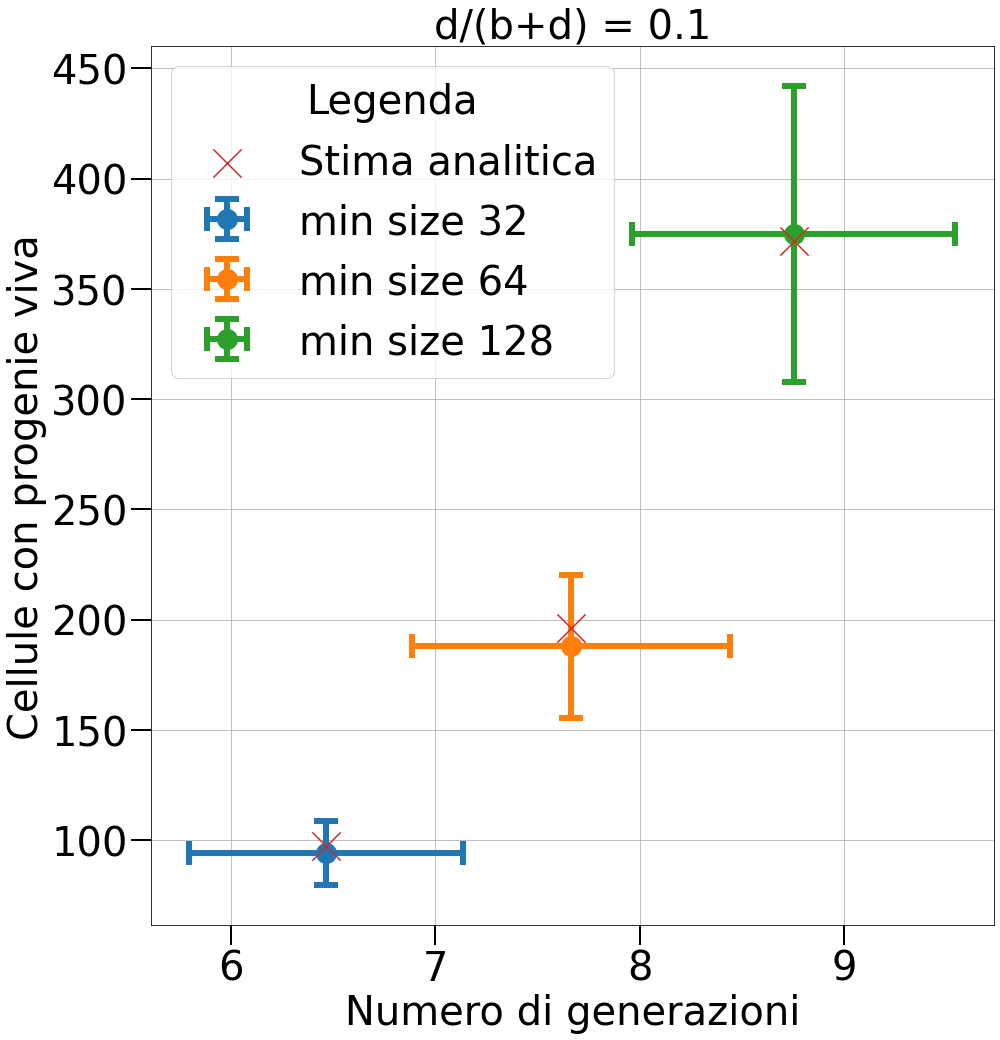

Mean count:
[93.946, 187.792, 374.919]
Std count:
[14.504933091882913, 32.23238644593354, 66.9482668857081]
Mean gen:
[6.466, 7.665, 8.754]
Std gen:
[0.6699582076517908, 0.7789576368455475, 0.7921388767129157]
Estimated:
[97.14487812068722, 196.28229534768667, 371.60681541187625]


In [3]:
# Test for (extant, count_with_alive_progeny) = (extant, attempts)
# For different minimum sizes we plot 
# (mean generation number, count_with_alive_progeny) with fixed death probability

# Note that extinct trees are discarded
print("Note that extinct trees are discarded!")

#variable parameter
min_sizes = [32, 64, 128]

#fixed death probability
death_prob = 0.1
print("Fixed death probability:", death_prob)

# Repeat simulations N times to get mean and devSt
N=1000

# results lists
mean_count = []
count_std = []
mean_gen = []
gen_std = []

# set seed to have reproducible results
np.random.seed(0)

# simulate
for min_size in min_sizes:
       
    # sigle runs results
    count = np.array([])
    gen = np.array([])
        
    for _ in range(N):
        tree = LD(bases = 1E+8, death_prob = death_prob, min_size = min_size, accept_extinct=False)
        tree.count_with_alive_progeny()
        count = np.append(count, tree._count_with_alive_progeny)
        gen = np.append(gen, tree._num_layers)
    
    #save this min size result
    mean_count.append(np.mean(count))
    count_std.append(np.std(count))
    mean_gen.append(np.mean(gen))
    gen_std.append(np.std(gen))   
    
#analytic estimation
estimated = []
for t in mean_gen:
    attempts = 0.
    # mean number of cell with at least one alive daughter
    # from generation zero to the second-last one

    # math.modf(x) split x in the integer and decimal part
    # for example math.modf(1.33)= [0.33, 1.0]
    for i in range(1, int(math.modf(t)[1])): #sum from i=1 to i = integer t
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
    
    # if decimal part for t is not zero we linearly interpolate
    # between the integer generation 
    pre = ( (2*(1-death_prob))**math.modf(t)[1])*1.*(1-death_prob**2)
    # and the next one 
    post = ( (2*(1-death_prob))**(math.modf(t)[1]+1))*1.*(1-death_prob**2)
    
    attempts += (post - pre)*math.modf(t)[0]
        
    # we add also the mean number of cells in the last layer 
    attempts += 1. * math.pow(2*(1-death_prob), t)

    estimated.append(attempts)
    

#
#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(5, 10)
#ax.set_ylim(50, 460)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)


for i in range(len(min_sizes)):
    ax.errorbar(mean_gen[i], mean_count[i], yerr=count_std[i], xerr=gen_std[i],
         marker ='o', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='min size '+str(min_sizes[i]))
    
ax.scatter(mean_gen, estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)

#plt.savefig("attempts_size_sum_0.1.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(count_std)
print("Mean gen:")
print(mean_gen)
print("Std gen:")
print(gen_std)
print("Estimated:")
print(estimated)

Note that extinct trees are discarded!
Fixed death probability: 0.2


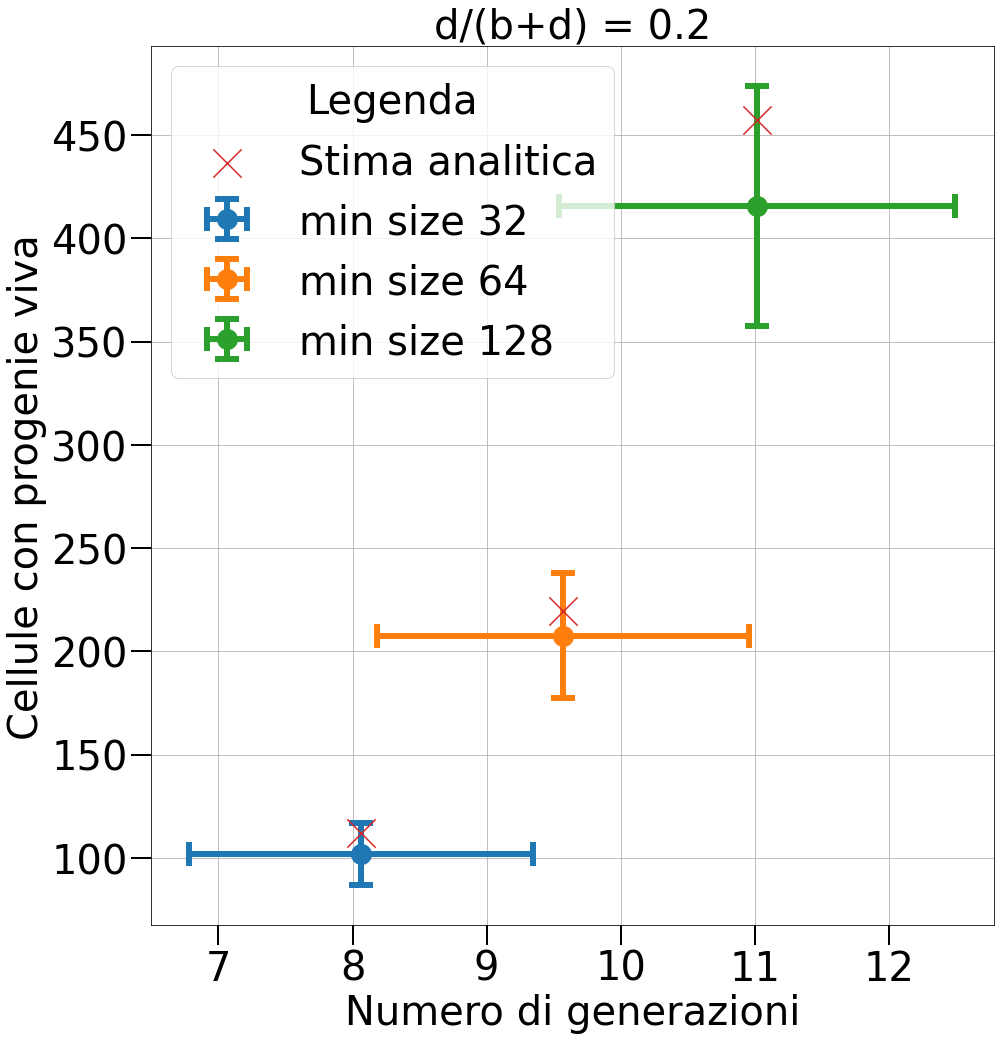

Mean count:
[101.833, 207.64, 415.61]
Std count:
[15.128090130614638, 30.167107915741607, 57.96188316471437]
Mean gen:
[8.065, 9.566, 11.014]
Std gen:
[1.280146475994056, 1.386233746523291, 1.477769941499691]
Estimated:
[112.04955659333191, 219.45749963008433, 457.41686263511156]


In [4]:
# Test for (extant, count_with_alive_progeny) = (extant, attempts)
# For different minimum sizes we plot 
# (mean generation number, count_with_alive_progeny) with fixed death probability

# Note that extinct trees are discarded
print("Note that extinct trees are discarded!")

#variable parameter
min_sizes = [32, 64, 128]

#fixed death probability
death_prob = 0.2
print("Fixed death probability:", death_prob)

# Repeat simulations N times to get mean and devSt
N=1000

# results lists
mean_count = []
count_std = []
mean_gen = []
gen_std = []

# set seed to have reproducible results
np.random.seed(0)

# simulate
for min_size in min_sizes:
       
    # sigle runs results
    count = np.array([])
    gen = np.array([])
        
    for _ in range(N):
        tree = LD(bases = 1E+8, death_prob = death_prob, min_size = min_size, accept_extinct=False)
        tree.count_with_alive_progeny()
        count = np.append(count, tree._count_with_alive_progeny)
        gen = np.append(gen, tree._num_layers)
    
    #save this min size result
    mean_count.append(np.mean(count))
    count_std.append(np.std(count))
    mean_gen.append(np.mean(gen))
    gen_std.append(np.std(gen))   
    
#analytic estimation
estimated = []
for t in mean_gen:
    attempts = 0.
    # mean number of cell with at least one alive daughter
    # from generation zero to the second-last one

    # math.modf(x) split x in the integer and decimal part
    # for example math.modf(1.33)= [0.33, 1.0]
    for i in range(1, int(math.modf(t)[1])): #sum from i=1 to i = integer t
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
    
    # if decimal part for t is not zero we linearly interpolate
    # between the integer generation 
    pre = ( (2*(1-death_prob))**math.modf(t)[1])*1.*(1-death_prob**2)
    # and the next one 
    post = ( (2*(1-death_prob))**(math.modf(t)[1]+1))*1.*(1-death_prob**2)
    
    attempts += (post - pre)*math.modf(t)[0]
        
    # we add also the mean number of cells in the last layer 
    attempts += 1. * math.pow(2*(1-death_prob), t)

    estimated.append(attempts)
    


#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(5, 10)
#ax.set_ylim(50, 460)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)


for i in range(len(min_sizes)):
    ax.errorbar(mean_gen[i], mean_count[i], yerr=count_std[i], xerr=gen_std[i],
         marker ='o', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='min size '+str(min_sizes[i]))
    
ax.scatter(mean_gen, estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)

#plt.savefig("attempts_size_sum_0.2.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(count_std)
print("Mean gen:")
print(mean_gen)
print("Std gen:")
print(gen_std)
print("Estimated:")
print(estimated)

Note that extinct trees are discarded!
Fixed death probability: 0.3


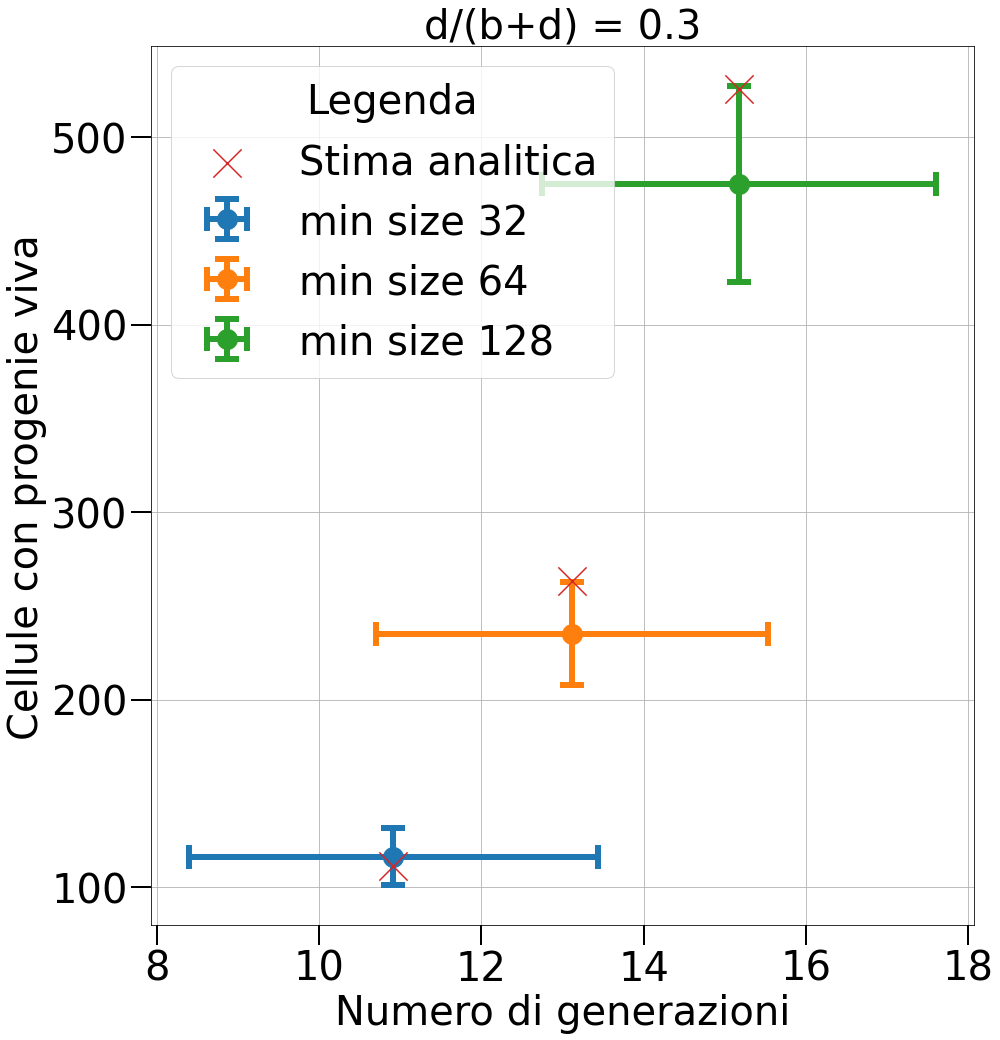

Mean count:
[116.077, 235.212, 474.914]
Std count:
[15.168489410616997, 27.256248017656432, 52.153471639000216]
Mean gen:
[10.909, 13.12, 15.176]
Std gen:
[2.522839471706434, 2.417767565337909, 2.4333154337241196]
Estimated:
[111.4656832407439, 263.49386850535893, 525.7576785901599]


In [5]:
# Test for (extant, count_with_alive_progeny) = (extant, attempts)
# For different minimum sizes we plot 
# (mean generation number, count_with_alive_progeny) with fixed death probability

# Note that extinct trees are discarded
print("Note that extinct trees are discarded!")

#variable parameter
min_sizes = [32, 64, 128]

#fixed death probability
death_prob = 0.3
print("Fixed death probability:", death_prob)

# Repeat simulations N times to get mean and devSt
N=1000

# results lists
mean_count = []
count_std = []
mean_gen = []
gen_std = []

# set seed to have reproducible results
np.random.seed(0)

# simulate
for min_size in min_sizes:
       
    # sigle runs results
    count = np.array([])
    gen = np.array([])
        
    for _ in range(N):
        tree = LD(bases = 1E+8, death_prob = death_prob, min_size = min_size, accept_extinct=False)
        tree.count_with_alive_progeny()
        count = np.append(count, tree._count_with_alive_progeny)
        gen = np.append(gen, tree._num_layers)
    
    #save this min size result
    mean_count.append(np.mean(count))
    count_std.append(np.std(count))
    mean_gen.append(np.mean(gen))
    gen_std.append(np.std(gen))   
    
#analytic estimation
estimated = []
for t in mean_gen:
    attempts = 0.
    # mean number of cell with at least one alive daughter
    # from generation zero to the second-last one

    # math.modf(x) split x in the integer and decimal part
    # for example math.modf(1.33)= [0.33, 1.0]
    
    for i in range(1, int(math.modf(t)[1])): #sum from i=1 to i = integer t
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
    
    # if decimal part for t is not zero we linearly interpolate
    # between the integer generation 
    pre = ( (2*(1-death_prob))**math.modf(t)[1])*1.*(1-death_prob**2)
    # and the next one 
    post = ( (2*(1-death_prob))**(math.modf(t)[1]+1))*1.*(1-death_prob**2)
    
    attempts += (post - pre)*math.modf(t)[0]
    
        
    # we add also the mean number of cells in the last layer 
    attempts += 1. * math.pow(2*(1-death_prob), t)
    
    estimated.append(attempts)
    


#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(5, 10)
#ax.set_ylim(50, 460)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)


for i in range(len(min_sizes)):
    ax.errorbar(mean_gen[i], mean_count[i], yerr=count_std[i], xerr=gen_std[i],
         marker ='o', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='min size '+str(min_sizes[i]))
    
ax.scatter(mean_gen, estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)

#plt.savefig("attempts_size_sum_0.3.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(count_std)
print("Mean gen:")
print(mean_gen)
print("Std gen:")
print(gen_std)
print("Estimated:")
print(estimated)

Note that extinct trees are discarded!
Fixed death probability: 0.4


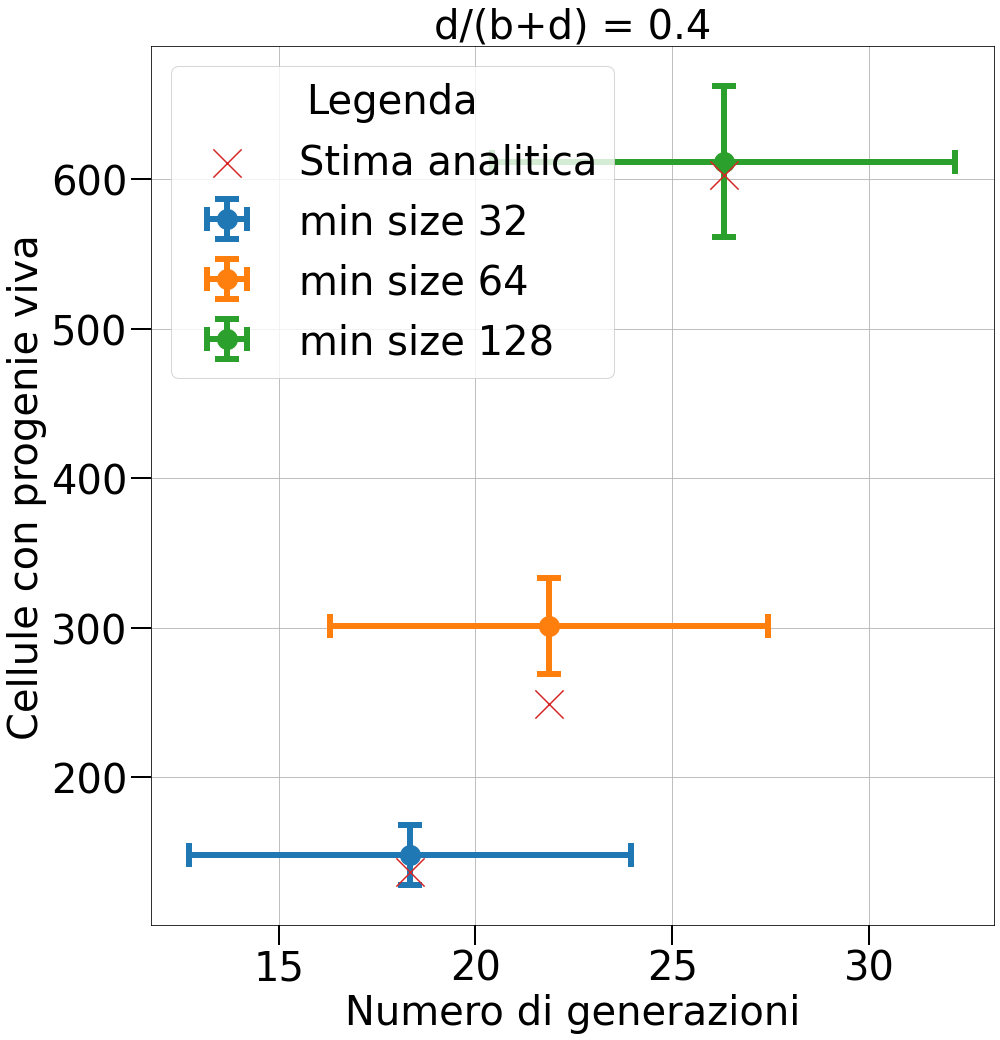

Mean count:
[148.008, 301.313, 611.648]
Std count:
[20.277325661930867, 31.95989723074841, 50.49825834620437]
Mean gen:
[18.337, 21.873, 26.305]
Std gen:
[5.601199068056768, 5.5662259206755165, 5.882174342876961]
Estimated:
[136.59573921787123, 248.8713388382138, 602.6441950822965]


In [6]:
# Test for (extant, count_with_alive_progeny) = (extant, attempts)
# For different minimum sizes we plot 
# (mean generation number, count_with_alive_progeny) with fixed death probability

# Note that extinct trees are discarded
print("Note that extinct trees are discarded!")

#variable parameter
min_sizes = [32, 64, 128]

#fixed death probability
death_prob = 0.4
print("Fixed death probability:", death_prob)

# Repeat simulations N times to get mean and devSt
N=1000

# results lists
mean_count = []
count_std = []
mean_gen = []
gen_std = []

# set seed to have reproducible results
np.random.seed(0)

# simulate
for min_size in min_sizes:
       
    # sigle runs results
    count = np.array([])
    gen = np.array([])
        
    for _ in range(N):
        tree = LD(bases = 1E+8, death_prob = death_prob, min_size = min_size, accept_extinct=False)
        tree.count_with_alive_progeny()
        count = np.append(count, tree._count_with_alive_progeny)
        gen = np.append(gen, tree._num_layers)
    
    #save this min size result
    mean_count.append(np.mean(count))
    count_std.append(np.std(count))
    mean_gen.append(np.mean(gen))
    gen_std.append(np.std(gen))   
    
#analytic estimation
estimated = []
for t in mean_gen:
    attempts = 0.
    # mean number of cell with at least one alive daughter
    # from generation zero to the second-last one

    # math.modf(x) split x in the integer and decimal part
    # for example math.modf(1.33)= [0.33, 1.0]
    for i in range(1, int(math.modf(t)[1])): #sum from i=1 to i = integer t
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
    
    # if decimal part for t is not zero we linearly interpolate
    # between the integer generation 
    pre = ( (2*(1-death_prob))**math.modf(t)[1])*1.*(1-death_prob**2)
    # and the next one 
    post = ( (2*(1-death_prob))**(math.modf(t)[1]+1))*1.*(1-death_prob**2)
    
    attempts += (post - pre)*math.modf(t)[0]
    
        
    # we add also the mean number of cells in the last layer 
    attempts += 1. * math.pow(2*(1-death_prob), t)
    
    estimated.append(attempts)
    


#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(5, 10)
#ax.set_ylim(50, 460)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)


for i in range(len(min_sizes)):
    ax.errorbar(mean_gen[i], mean_count[i], yerr=count_std[i], xerr=gen_std[i],
         marker ='o', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='min size '+str(min_sizes[i]))
    
ax.scatter(mean_gen, estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)

#plt.savefig("attempts_size_sum_0.4.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(count_std)
print("Mean gen:")
print(mean_gen)
print("Std gen:")
print(gen_std)
print("Estimated:")
print(estimated)

### Here trees are built until a fixed number of generations.

Section 3.5.4, figure 15.

Extinct trees are accepted!


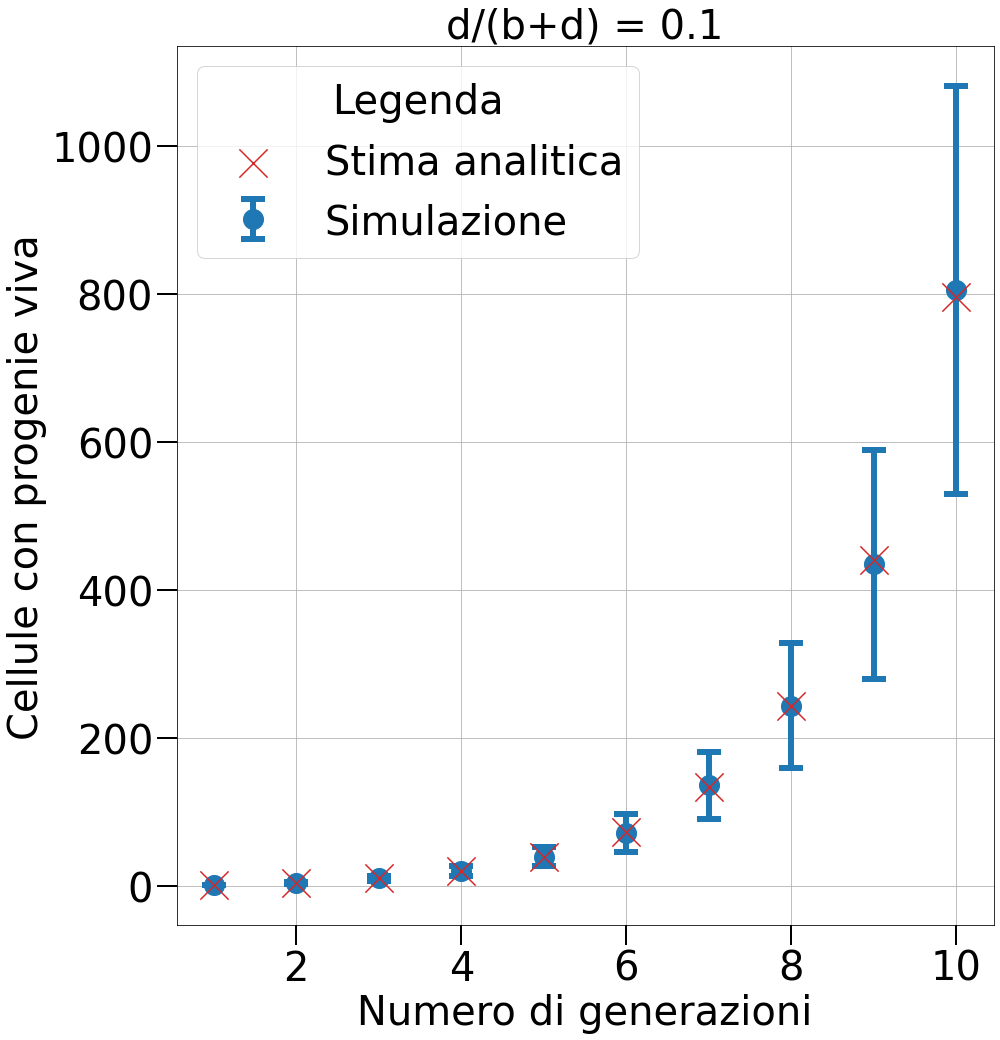

Mean count:
[  1.786   5.003  10.71   21.02   39.888  72.188 136.368 243.843 435.011
 805.621]
Std count:
[  0.42450442   1.41597705   3.21899052   6.80937589  12.78770722
  25.34684706  45.85979259  84.39224106 154.89190708 275.57316516]
Estimated:
[  1.8          5.022       10.8216      21.26088     40.051584
  73.8748512  134.75673216 244.34411789 441.6014122  796.66454196]


In [7]:
# Instead of using a minimum size to build the tree,
# a test with fixed numeber of generations is made here.

# fixed number of generations (time max)
max_gen = 10
# Number of simulations
N = 1000
# Death probability
death_prob = 0.1

print("Extinct trees are accepted!")
    
mean_count = np.zeros(max_gen)
std_count = np.zeros(max_gen)
estimated = np.zeros(max_gen)
    
for gen in range(max_gen) :
        
    this_gen_this_prob_count = []
        
    for _ in range (N):
        tree = LD(bases = 1E+8, death_prob = death_prob, gen=gen+1, accept_extinct=True)
        tree.count_with_alive_progeny()
        this_gen_this_prob_count.append(tree._count_with_alive_progeny)
            
    mean_count[gen] = np.mean(this_gen_this_prob_count)
    std_count[gen] = np.std(this_gen_this_prob_count)
        
    # Analytic estimation
    # In formulas t = gen, but here gen starts from zero
    t = gen + 1
    attempts = 0.   
        
    # we count the cumulative mean number of cell
    # with at least one alive daughter
    # from generation zero to the second-last one
    for i in range(1, t): #from i=0 to i=t-1
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
            
    # we add also add extant cells number
    attempts += 1. * math.pow(2*(1-death_prob), t)
        
    # we don't want to count root cell
    #attempts -= 1
    estimated[gen] = attempts

               
#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(0.5, 10.5)
#ax.set_ylim(-20, 1150)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)

ax.errorbar(np.arange(1, max_gen+1), mean_count, yerr=std_count,
         marker ='o', c='tab:blue', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='Simulazione')
    
plt.scatter(np.arange(1, max_gen+1), estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)



#plt.savefig("attempts_gen_sum_0.1.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(std_count)
print("Estimated:")
print(estimated)
    

Extinct trees are accepted!


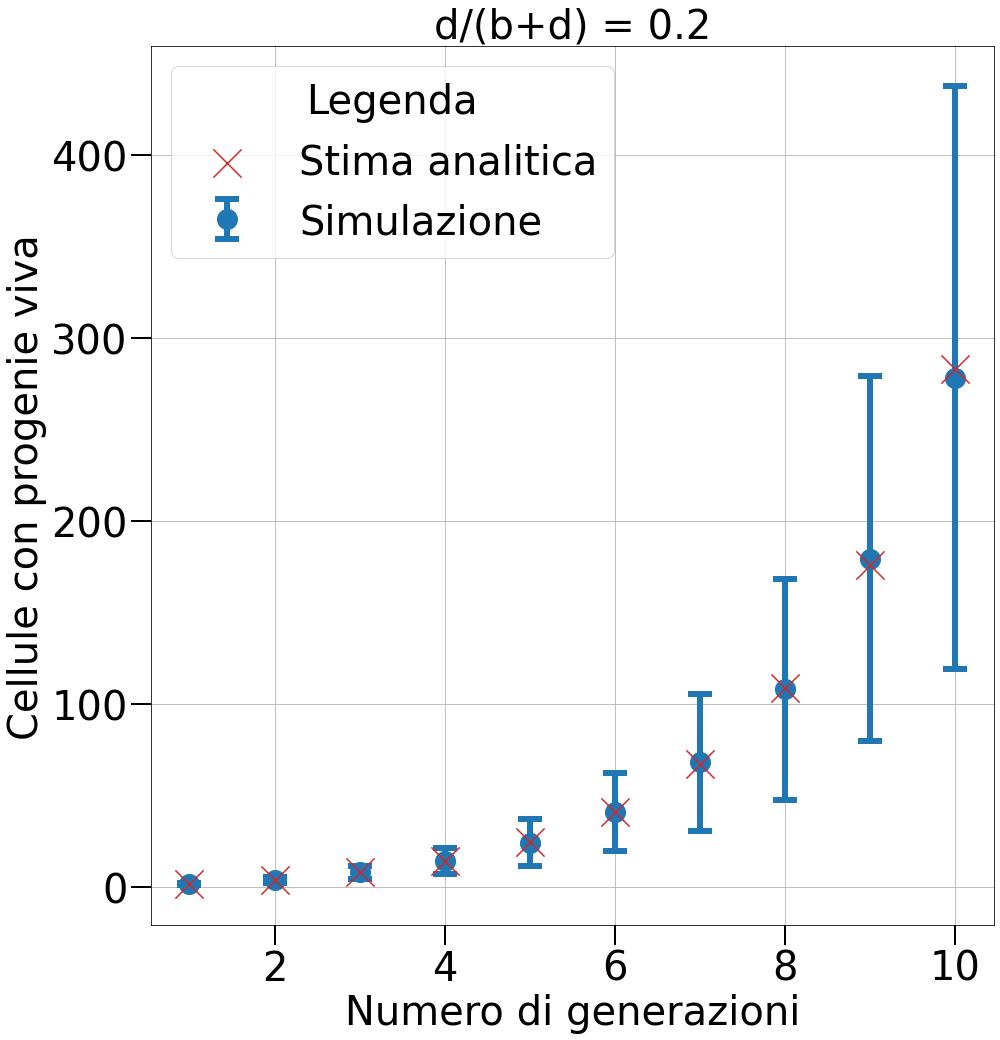

Mean count:
[  1.61    4.202   8.21   14.27   24.452  41.087  68.239 108.126 179.619
 278.453]
Std count:
[  0.56559703   1.67008862   3.65320407   7.10486453  12.64909862
  21.40848969  37.56759081  60.54112754  99.94377339 159.16450544]
Estimated:
[  1.6          4.096        8.0896      14.47936     24.702976
  41.0607616   67.23321856 109.1091497  176.11063951 283.31302322]


In [8]:
# Instead of using a minimum size to build the tree,
# a test with fixed numeber of generations is made here.

# fixed number of generations (time max)
max_gen = 10
# Number of simulations
N = 1000
# Death probability
death_prob = 0.2

print("Extinct trees are accepted!")
    
mean_count = np.zeros(max_gen)
std_count = np.zeros(max_gen)
estimated = np.zeros(max_gen)
    
for gen in range(max_gen) :
        
    this_gen_this_prob_count = []
        
    for _ in range (N):
        tree = LD(bases = 1E+8, death_prob = death_prob, gen=gen+1, accept_extinct=True)
        tree.count_with_alive_progeny()
        this_gen_this_prob_count.append(tree._count_with_alive_progeny)
            
    mean_count[gen] = np.mean(this_gen_this_prob_count)
    std_count[gen] = np.std(this_gen_this_prob_count)
        
    # Analytic estimation
    # In formulas t = gen, but here gen starts from zero
    t = gen + 1
    attempts = 0.   
        
    # we count the cumulative mean number of cell
    # with at least one alive daughter
    # from generation zero to the second-last one
    for i in range(1, t): #from i=0 to i=t-1
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
            
    # we add also add extant cells number
    attempts += 1. * math.pow(2*(1-death_prob), t)
        
    # we don't want to count root cell
    #attempts -= 1
    estimated[gen] = attempts

               
#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(0.5, 10.5)
#ax.set_ylim(-20, 1150)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)

ax.errorbar(np.arange(1, max_gen+1), mean_count, yerr=std_count,
         marker ='o', c='tab:blue', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='Simulazione')
    
plt.scatter(np.arange(1, max_gen+1), estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)

#plt.savefig("attempts_gen_sum_0.2.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(std_count)
print("Estimated:")
print(estimated)
    

Extinct trees are accepted!


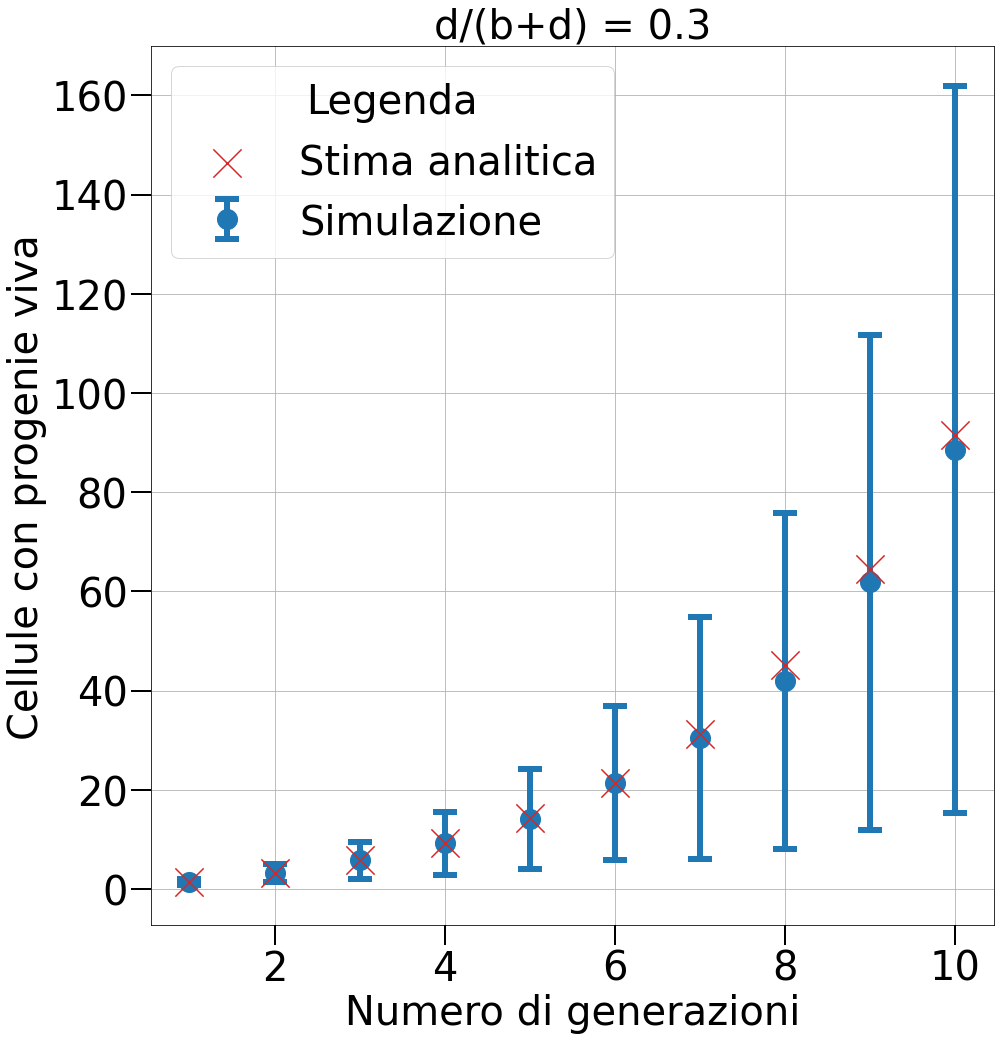

Mean count:
[ 1.409  3.305  5.777  9.234 14.11  21.441 30.467 41.99  61.837 88.587]
Std count:
[ 0.64631184  1.78380913  3.69097155  6.30644464 10.09692527 15.55887268
 24.30302267 33.87890051 49.92036089 73.22499868]
Estimated:
[ 1.4         3.234       5.8016      9.39624    14.428736   21.4742304
 31.33792256 45.14709158 64.47992822 91.5458995 ]


In [9]:
# Instead of using a minimum size to build the tree,
# a test with fixed numeber of generations is made here.

# fixed number of generations (time max)
max_gen = 10
# Number of simulations
N = 1000
# Death probability
death_prob = 0.3

print("Extinct trees are accepted!")
    
mean_count = np.zeros(max_gen)
std_count = np.zeros(max_gen)
estimated = np.zeros(max_gen)
    
for gen in range(max_gen) :
        
    this_gen_this_prob_count = []
        
    for _ in range (N):
        tree = LD(bases = 1E+8, death_prob = death_prob, gen=gen+1, accept_extinct=True)
        tree.count_with_alive_progeny()
        this_gen_this_prob_count.append(tree._count_with_alive_progeny)
            
    mean_count[gen] = np.mean(this_gen_this_prob_count)
    std_count[gen] = np.std(this_gen_this_prob_count)
        
    # Analytic estimation
    # In formulas t = gen, but here gen starts from zero
    t = gen + 1
    attempts = 0.   
        
    # we count the cumulative mean number of cell
    # with at least one alive daughter
    # from generation zero to the second-last one
    for i in range(1, t): #from i=0 to i=t-1
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
            
    # we add also add extant cells number
    attempts += 1. * math.pow(2*(1-death_prob), t)
        
    # we don't want to count root cell
    #attempts -= 1
    estimated[gen] = attempts

               
#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(0.5, 10.5)
#ax.set_ylim(-20, 1150)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)

ax.errorbar(np.arange(1, max_gen+1), mean_count, yerr=std_count,
         marker ='o', c='tab:blue', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='Simulazione')
    
plt.scatter(np.arange(1, max_gen+1), estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)


#plt.savefig("attempts_gen_sum_0.3.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(std_count)
print("Estimated:")
print(estimated)
    

Extinct trees are accepted!


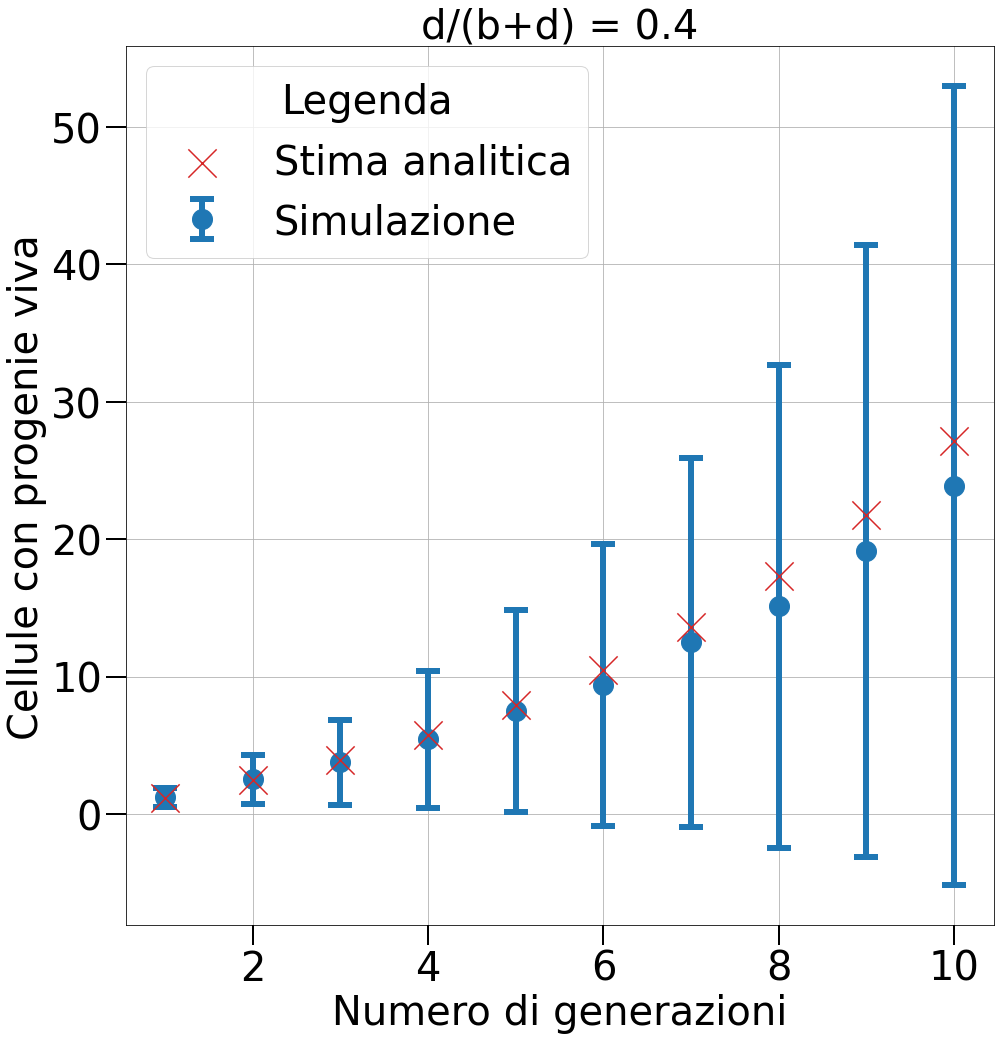

Mean count:
[ 1.214  2.518  3.752  5.428  7.501  9.4   12.494 15.13  19.153 23.887]
Std count:
[ 0.70441749  1.80988287  3.11424084  5.00907337  7.32502553 10.27141665
 13.45496057 17.56829815 22.26291964 29.07955005]
Estimated:
[ 1.2         2.448       3.9456      5.74272     7.899264   10.4871168
 13.59254016 17.31904819 21.79085783 27.1570294 ]


In [10]:
# Instead of using a minimum size to build the tree,
# a test with fixed numeber of generations is made here.

# fixed number of generations (time max)
max_gen = 10
# Number of simulations
N = 1000
# Death probability
death_prob = 0.4

print("Extinct trees are accepted!")
    
mean_count = np.zeros(max_gen)
std_count = np.zeros(max_gen)
estimated = np.zeros(max_gen)
    
for gen in range(max_gen) :
        
    this_gen_this_prob_count = []
        
    for _ in range (N):
        tree = LD(bases = 1E+8, death_prob = death_prob, gen=gen+1, accept_extinct=True)
        tree.count_with_alive_progeny()
        this_gen_this_prob_count.append(tree._count_with_alive_progeny)
            
    mean_count[gen] = np.mean(this_gen_this_prob_count)
    std_count[gen] = np.std(this_gen_this_prob_count)
        
    # Analytic estimation
    # In formulas t = gen, but here gen starts from zero
    t = gen + 1
    attempts = 0.   
        
    # we count the cumulative mean number of cell
    # with at least one alive daughter
    # from generation zero to the second-last one
    for i in range(1, t): #from i=0 to i=t-1
        attempts += ( (2*(1-death_prob))**i)*1.*(1-death_prob**2)
            
    # we add also add extant cells number
    attempts += 1. * math.pow(2*(1-death_prob), t)
        
    # we don't want to count root cell
    #attempts -= 1
    estimated[gen] = attempts

               
#plot results
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Numero di generazioni', fontsize=40)
ax.set_ylabel('Cellule con progenie viva', fontsize=40)
ax.yaxis.offsetText.set_fontsize(40)

### set x y range
#ax.set_xlim(0.5, 10.5)
#ax.set_ylim(-20, 1150)

## set ticks
ax.tick_params(which='major', width=2.0, labelsize=40)
ax.tick_params(which='major', length=20, labelsize=40)

ax.errorbar(np.arange(1, max_gen+1), mean_count, yerr=std_count,
         marker ='o', c='tab:blue', capsize=12, capthick=6, lw=6,fmt=' ',markersize=20,
         label='Simulazione')
    
plt.scatter(np.arange(1, max_gen+1), estimated, marker = 'x', s=800, label = 'Stima analitica', color = 'tab:red',zorder=10)

ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
plt.tight_layout()
plt.grid()
plt.title("d/(b+d) = "+str(death_prob), fontsize=40)


#plt.savefig("attempts_gen_sum_0.4.pdf")
plt.show()

print("Mean count:")
print(mean_count)
print("Std count:")
print(std_count)
print("Estimated:")
print(estimated)
    

## Test LD estimator corrected by the discrete time model
Section 3.5.4, figure 16.

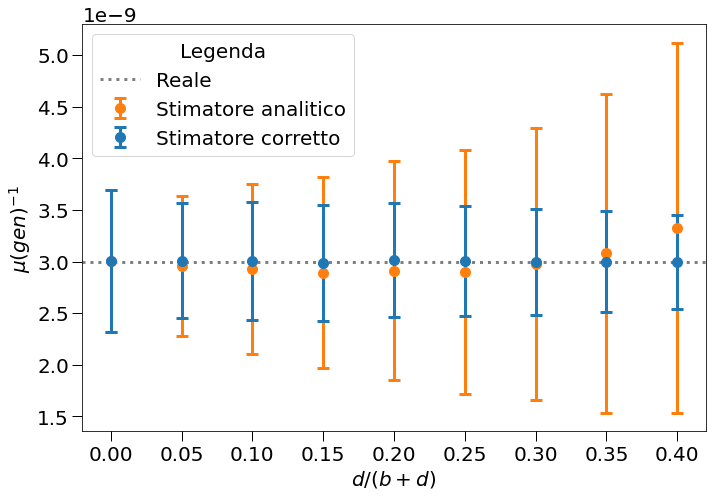

death probabilities
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ]

estimated mu no-dead
[3.0044196493465068e-09, 3.0063814144156328e-09, 3.003225056244504e-09, 2.9857916139100338e-09, 3.013139491937501e-09, 3.0009427402229657e-09, 2.9956210436296037e-09, 2.999500684241932e-09, 2.9953196198383713e-09]

estimated mu no-dead std
[6.899301005751771e-10, 5.56040105773631e-10, 5.736105685183644e-10, 5.651038709653792e-10, 5.534125086579583e-10, 5.325361021031894e-10, 5.146627734955256e-10, 4.868150023352101e-10, 4.53532314449797e-10]

estimated mu no-dead estimated
[3.0044196493465068e-09, 2.9562558244075093e-09, 2.9258721308334437e-09, 2.891588831577784e-09, 2.911441679946469e-09, 2.8968427367624704e-09, 2.974188769500234e-09, 3.078455204701311e-09, 3.3261584261352458e-09]

estimated mu no-dead estimated std
[6.899301005751771e-10, 6.752635296182019e-10, 8.229980190291735e-10, 9.227830172349778e-10, 1.0614088715198508e-09, 1.17910204994009e-09, 1.3184445576033446e-09, 1.5410493441533637e-0

In [11]:
# Repeat simulations N times to get mean estimated mut rate and devSt

N = 10000 # number of simulation for each death probability
# N = 1000, time ~ 15 s
# N = 10^4, time ~ 150 s

# variable parameter
death_probabilities = np.linspace(0., 0.4, 9)

# results lists
# mean values
est_mu_no_dead = list([]) # using known number of cell with alive progeny
est_mu_no_dead_estimated = list([]) # using analytic estimate 
# standard deviations
est_mu_no_dead_std = list([])
est_mu_no_dead_estimated_std = list([])

# set seed to have reproducible results
np.random.seed(0)

# simulate
for death_prob in death_probabilities:
    # sigle runs results
    mu_no_dead = np.array([])
    mu_no_dead_estimated = np.array([])

    # perform N single runs
    for _ in np.arange(N):
        tree = LD(bases = 1E+8, death_prob = death_prob, min_size = 32)
        tree.test_LD_estimator_no_dead()
        tree.test_LD_estimator_no_dead_estimated()
        
        #save single run results
        mu_no_dead = np.append(mu_no_dead, tree._mu_est_no_dead)
        mu_no_dead_estimated = np.append(mu_no_dead_estimated, tree._mu_est_no_dead_estimated)
        
    # save results from N runs    
    est_mu_no_dead.append(np.mean(mu_no_dead))
    est_mu_no_dead_std.append(np.std(mu_no_dead))
    
    est_mu_no_dead_estimated.append(np.mean(mu_no_dead_estimated))
    est_mu_no_dead_estimated_std.append(np.std(mu_no_dead_estimated))    
    
#plot results
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
#plt.title('Stimatore corretto analiticamente\n'+str(N)+' simulazioni ogni punto')
ax.set_xlabel(r'$d/(b+d)$', fontsize=20)
ax.set_ylabel(r'$\mu (gen)^{-1}$', fontsize=20)
ax.yaxis.offsetText.set_fontsize(20)

## set ticks
ax.tick_params(which='major', width=1.0, labelsize=20)
ax.tick_params(which='major', length=10, labelsize=20)

ax.errorbar(death_probabilities, est_mu_no_dead_estimated, yerr=est_mu_no_dead_estimated_std,
         marker ='o', c='tab:orange', capsize=6, capthick=3, lw=3,fmt=' ',markersize=10,
         label='Stimatore analitico')

plt.errorbar(death_probabilities, est_mu_no_dead, yerr=est_mu_no_dead_std,
         marker ='o', c='tab:blue', capsize=6, capthick=3, lw=3,fmt=' ',markersize=10,
         label='Stimatore corretto')



ax.axhline(y=tree._mu,  label='Reale', c='tab:gray',lw=3, ls=':')
ax.legend(fontsize=20, title='Legenda',title_fontsize=20)
plt.tight_layout()
  

#plt.savefig('dead_cells_estimated_correction_sum.pdf')
plt.show()     

# print results
print("death probabilities")
print(death_probabilities)
print("\nestimated mu no-dead")
print(est_mu_no_dead)
print("\nestimated mu no-dead std")
print(est_mu_no_dead_std)
print("\nestimated mu no-dead estimated")
print(est_mu_no_dead_estimated)
print("\nestimated mu no-dead estimated std")
print(est_mu_no_dead_estimated_std)